In [17]:
import os

import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qiskit.providers.ibmq.managed import IBMQJobManager
from qutip import Bloch, Bloch3d, Qobj

from sync_gates import add_tomography
from sync_calcs import dm2bloch

load_dotenv()

# IBMQ.ibmq.save_account(os.environ['TOKEN'], overwrite=True)


True

In [18]:
# IBMQ.load_account()

In [19]:
provider = IBMQ.get_provider(group='open', project='main')

job_manager = IBMQJobManager()

backend = provider.get_backend('ibmq_santiago') # Real - ibmq_santiago seems to have the lowest CNOT noise
# backend = AerSimulator.from_backend(backend) # Noisy Sim
# backend = AerSimulator() # Ideal Sim

is_real_device = not backend.name().startswith('aer_simulator')

max_shots = backend.configuration().to_dict()["max_shots"]
max_shots

8192

# Parameters

In [20]:
# Simulation Steps
SIM_STEPS = 10
SHOTS = max_shots

gain_amp = 0.1
loss_amp = 1
m = min(loss_amp, gain_amp)

detuning = 10 * 3 * m
signal_strength = 10 * 2 * m
dt = 0.5

theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

# Circuit

In [21]:
def generate_circuit(dt, detuning, signal_strength, steps):
    z_arg = -detuning * dt / 2
    y_arg = -signal_strength * dt

    qreg_q = QuantumRegister(2, "q")
    creg_c = ClassicalRegister(1, "c")

    qc = QuantumCircuit(qreg_q, creg_c)

    for _ in range(steps):
        qc.u(z_arg, y_arg, z_arg, qreg_q[0])

        # Loss CU
        # qc.cu(theta_d, 0, 0, 0, qreg_q[0], qreg_q[1])
        # qc.cx(qreg_q[1], qreg_q[0])
        # qc.measure(qreg_q[1], creg_c[0])
        # qc.reset(qreg_q[1])

        # Loss 2xCX
        qc.u(pi / 2, -pi, 0, qreg_q[0])
        qc.u(-theta_d / 2, -pi / 2, pi, qreg_q[1])
        qc.cx(qreg_q[1], qreg_q[0])
        qc.u(pi / 2, -pi / 2, 0, qreg_q[0])
        qc.u(-theta_d / 2, pi, pi / 2, qreg_q[1])
        qc.cx(qreg_q[1], qreg_q[0])
        qc.u(0, 0, -pi/2, qreg_q[0])
        qc.u(0, 0, -pi/2, qreg_q[1])
        qc.measure(qreg_q[1], creg_c[0])
        qc.reset(qreg_q[1])

        # # Gain
        qc.u(-pi, 0, 0, qreg_q[0])
        qc.cx(qreg_q[0], qreg_q[1])
        qc.cu(theta_g, 0, 0, 0, qreg_q[0], qreg_q[1])
        qc.cx(qreg_q[0], qreg_q[1])
        qc.u(pi, 0, 0, qreg_q[0])
        qc.measure(qreg_q[1], creg_c[0])
        qc.reset(qreg_q[1])

    return qc


# Tomography

In [22]:
circuits = [generate_circuit(dt, detuning, signal_strength, i) for i in range(0, SIM_STEPS + 1)]

circuits_with_tomo = [list(add_tomography(circuit)) for circuit in circuits]

compiled_circuits_with_tomo = [transpile(circuit, backend) for circuit in circuits_with_tomo]

# Calibration

In [23]:
measurement_calibration_circuit, state_labels = mc.complete_meas_cal(qubit_list=[0])

if is_real_device:
    calibration_job = job_manager.run(measurement_calibration_circuit, backend=backend, name="QSync_calibration")
    result = calibration_job.results().combine_results()
else:
    calibration_job = backend.run(measurement_calibration_circuit, shots=SHOTS)
    result = calibration_job.result()

measurement_calibration_fitter = mc.CompleteMeasFitter(result, state_labels)
measurement_calibration_fitter.cal_matrix

array([[0.99023438, 0.01660156],
       [0.00976562, 0.98339844]])

In [24]:
if not is_real_device:
    jobs = [backend.run(circuit, name=f"QSync_{i}", shots=SHOTS) for i, circuit in enumerate(compiled_circuits_with_tomo)]
else:
    jobs = [job_manager.run(circuit, backend=backend, name=f"QSync_{i}", shots=SHOTS) for i, circuit in enumerate(compiled_circuits_with_tomo)]

In [25]:
uncorrected_states = []

for job, circuit in zip(jobs, compiled_circuits_with_tomo):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    tomo_state = StateTomographyFitter(result, circuit)
    state = tomo_state.fit(method="lstsq")

    uncorrected_states.append(state)


managedjob._async_submit:WARNING:2021-05-12 11:13:23,807: Job limit reached, waiting for job 609baa43df1fcbef22ade16a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-12 11:13:23,810: Job limit reached, waiting for job 609baa43df1fcbef22ade16a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-12 11:13:23,857: Job limit reached, waiting for job 609baa43df1fcbef22ade16a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-12 11:13:23,878: Job limit reached, waiting for job 609baa43df1fcbef22ade16a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-12 11:13:23,893: Job limit reached, waiting for job 609baa43df1fcbef22ade16a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-12 11:13:24,014: Job limit reached, waiting for job 609baa43df1fcbef22ade16a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.79382324+0.j         -0.01342773-0.09667969j]
 [-0.01342773+0.09667969j  0.20617676+0.j        ]]

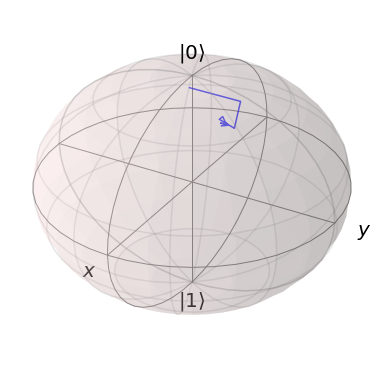

In [26]:
b = Bloch()
points = dm2bloch([Qobj(s) for s in uncorrected_states])
b.add_points(points, meth="l")

# b.view = [0, 90]
b.show()
Qobj(uncorrected_states[-1])

In [27]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Jobs File Name: ")

    with open(f"{name}.txt", "w") as f:
        f.write("Calibration:\n")
        f.write(f"{calibration_job.job_set_id()}\n")
        f.write("\n")
        f.write("Simulation:\n")
        for job in jobs:
            id_ = job.job_set_id()
            f.write(f"{id_}\n")

In [28]:
corrected_states = []

for job, circuit in zip(jobs, compiled_circuits_with_tomo):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    corrected_result = measurement_calibration_fitter.filter.apply(result, method="least_squares")
    mitigated_tomo_state = StateTomographyFitter(corrected_result, circuit)
    state = mitigated_tomo_state.fit(method="lstsq")

    corrected_states.append(state)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.79826981+0.j         -0.01730191-0.09578736j]
 [-0.01730191+0.09578736j  0.20173019+0.j        ]]

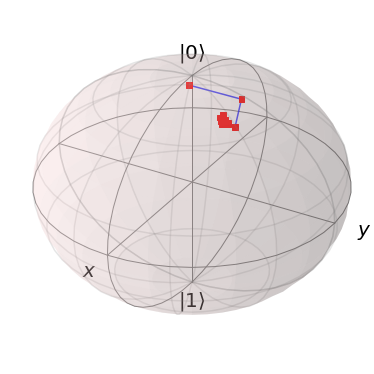

In [33]:
b = Bloch()
points = dm2bloch([Qobj(s) for s in corrected_states])
b.add_points(points, meth="l")
b.add_points(points, meth="s")
# b.view = [0, 90]
b.show()
Qobj(corrected_states[-1])

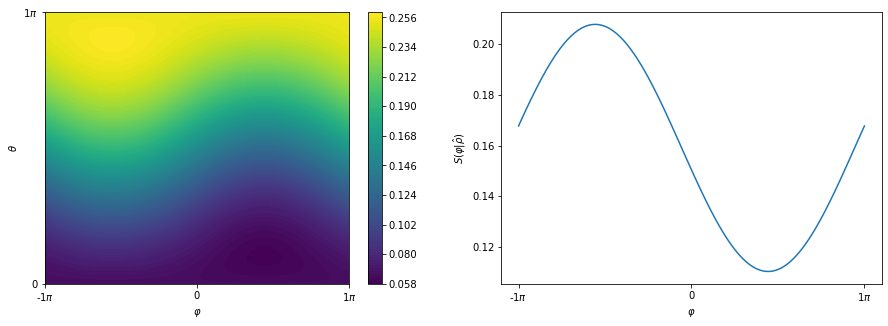

In [30]:
from sync_plots import calc_and_plot_Q_and_S
ss = corrected_states[-1]
calc_and_plot_Q_and_S(Qobj(ss), method="qutip")

In [ ]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Data File Name: ")
    np.save(f'{name}.npy', corrected_states)